In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os
import PIL
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import files, drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


***UNDUH DATA GAMBAR SAMPAH DARI KAGGLE (GDRIVE)***

https://www.kaggle.com/asdasdasasdas/garbage-classification

In [ ]:
#extract data dari drive ke cache lokal google colab (sesuaikan dengan gdrive masing2)
#run hanya 1x
!unzip -q 'dataset.zip'

In [ ]:
#tentukan data path
data_path = pathlib.Path('/content/Garbage classification/Garbage classification')

In [ ]:
#tampilkan total data
data_count = len(list(data_path.glob('*/*.jpg')))
print(data_count)

2527


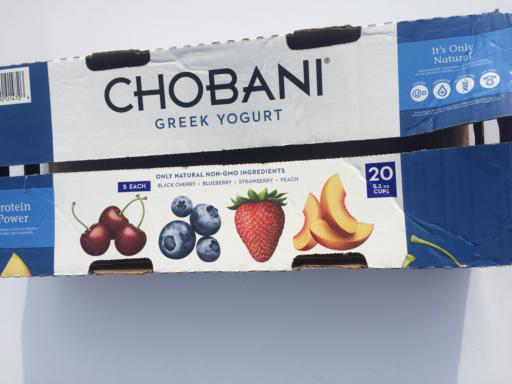

In [ ]:
#tampilkan contoh data
data_example = list(data_path.glob('cardboard/*'))
PIL.Image.open(str(data_example[0]))

***BUAT DATASET***

In [ ]:
#tentukan ukuran batch (untuk pemrosesan ml), tinggi dan lebar gambar
batch_size = 32
img_height = 192
img_width = 256

In [ ]:
#ambil data training dari masing-masing folder
#nama folder menjadi nama kelas masing-masing data
#80% diambil sebagai data training, 20% diambil sebagai data validasi
#penentuan seed bebas, sebagai acuan random generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [ ]:
#ambil data validasi dari masing-masing folder
#nama folder menjadi nama kelas masing-masing data
#80% diambil sebagai data training, 20% diambil sebagai data validasi
#penentuan seed bebas, sebagai acuan random generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
#ambil nama kelas
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


***TAMPILKAN CONTOH DATASET***

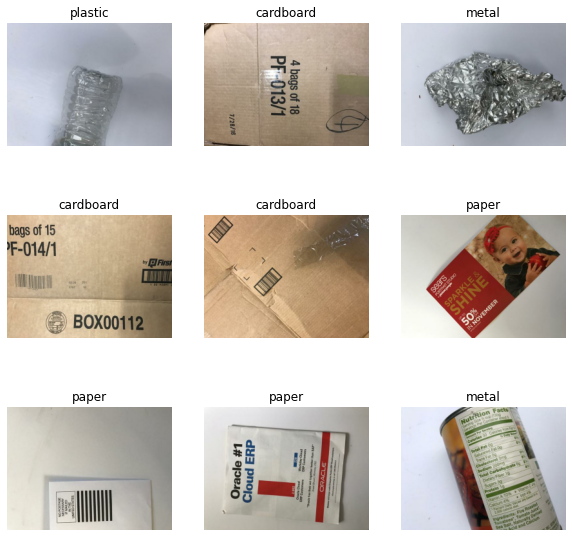

In [ ]:
#coba tampilkan dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
#coba print isi dari train_ds dan val_ds
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 192, 256, 3)
(32,)
(32, 192, 256, 3)
(32,)


***BUAT PEMODELAN MACHINE LEARNING (CNN)***

In [ ]:
#perlakuan train_ds dan val_ds dengan prefetch agar mempercepat 
#proses training karena prefetch segera mereplace data 
#iterasi sebelumnya dengan iterasi yang baru pada cache
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#penggunaan data augmentation, atau penambahan jumlah data
#diluar data train dan val, dengan bentuk berupa transformasi 
#setiap gambar. tujuan untuk meningkatkan akurasi
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip('horizontal',
                                                  input_shape=(img_height, img_width, 3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

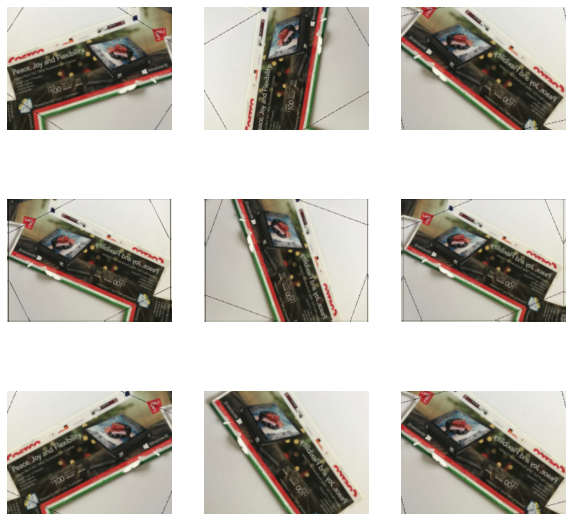

In [ ]:
# tampilkan contoh hasil penggunaan data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
#arsitektur model cnn
def create_model():
  num_classes = len(class_names)
  return Sequential(
      [
       data_augmentation,
       layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
       layers.Conv2D(16, 3, padding='same', activation='relu'),
       layers.MaxPooling2D(),
       layers.Conv2D(32, 3, padding='same', activation='relu'),
       layers.MaxPooling2D(),
       layers.Conv2D(64, 3, padding='same', activation='relu'),
       layers.MaxPooling2D(),
       layers.Flatten(),
       layers.Dense(128, activation='relu'),
       layers.Dense(num_classes)
    ]
)

***MODEL TANPA DISTRIBUTED ATAU PARALLEL***

Proses komputasi *Machine Learning* dilakukan pada 1 mesin utama, tanpa dibagi-bagi menjadi beberapa bagian mesin. 

In [ ]:
model = create_model()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 192, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 192, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 192, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 96, 128, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 64, 64)       

***LAKUKAN TRAINING MODEL***

In [ ]:
#lakukan training pada model dengan strategy
epochs = 10
start_time = time.time()
result = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)
print("waktu eksekusi: {} detik".format(time.time()-start_time))

Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CP

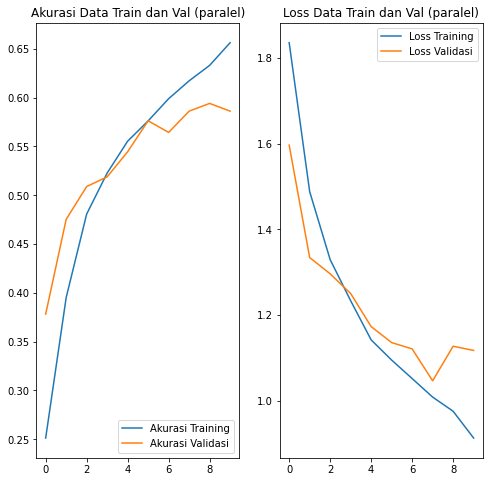

In [ ]:
#tampilkan grafik akurasi dan loss dari data train dan validasi model dengan strategy
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Data Train dan Val (paralel)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Data Train dan Val (paralel)')
plt.show()